In [1]:
!pip install celluloid

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
b1 = {
    'name': 'Bonds',
    'value_nominal': 500000,
    'expected_return': 0.025,
    'SRRI': 0.0125,
    'std': 0.02,
    'monthly_saving': 0.0,
    'liquid': True,
    'ISK': False,
}

s1 = {
    'name': 'Stocks',
    'value_nominal': 500000,
    'expected_return': 0.08,
    'SRRI': 0.15,
    'std': 0.18,
    'monthly_saving': 0.0,
    'liquid': True,
    'ISK': True
}

ba = {
    'name': 'Buffertkonto',
    'value_nominal': 0.0,
    'expected_return': 0.0065,
    'SRRI': 0.0,
    'std': 0.0,
    'monthly_saving': 0.0,
    'liquid': True,
    'ISK': False
}

p1 = {
    'Title': '1 mkr',
    'Stocks': s1,
    'Bonds': b1,
    'Bank account' : ba,
    'Share_stocks': 0.5,
    'net_value': {
        'total':   {
            'nominal': 0.0,
            'real': 0.0
        },
        'liquid':  {
            'nominal': 0.0,
            'real': 0.0
        },
        'low_volatility': {
            'nominal': 0.0,
            'real': 0.0
        }
    }
}

p2 = {
    'Title': '1 mkr',
    'Stocks': s1,
    'Bonds': b1,
    'Bank account' : ba,
    'Share_stocks': 0.7,
    'net_value': {
        'total':   {
            'nominal': 0.0,
            'real': 0.0
        },
        'liquid':  {
            'nominal': 0.0,
            'real': 0.0
        },
        'low_volatility': {
            'nominal': 0.0,
            'real': 0.0
        }
    }
}


asset_classes = ['Stocks', 'Bonds', 'Bank account']
liquidity_classes = ['total', 'liquid', 'low_volatility']

In [54]:
import numpy as np
import datetime
import pandas as pd
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from celluloid import Camera

class SimReturns:
    def __init__(self, portfolio: dict):
        self.portfolio = portfolio
        self.cumulative_inflation = 1.0
        self.year_balances = []
        self.__calc_net_value()
        self.__balance_stocks_and_bonds()
            
    def sim_returns(self, no_of_years):
        now = datetime.datetime.now()
        self.start_year = now.year
        net_val = copy.deepcopy(self.portfolio['net_value'])
        self.year_balances.append(net_val) # år 0
        for year in range(self.start_year + 1, self.start_year + no_of_years + 1):
            self.add_year()
            net_val = copy.deepcopy(self.portfolio['net_value'])
            self.year_balances.append(net_val)
            
    def get_asset(self, name):
        return next(item for item in self.assets if item["name"] == name)


    def sum_of_assets(self, liquidity_classes: str):
        sum = 0
        if liquidity_classes == 'total':
            for asset_class in asset_classes:
                sum += self.portfolio[asset_class]['value_nominal']
        elif liquidity_classes == 'liquid':
            for asset_class in asset_classes:
                if self.portfolio[asset_class]['liquid'] == True:
                    sum += self.portfolio[asset_class]['value_nominal']
        elif liquidity_classes == 'low_volatility':
            for asset_class in asset_classes:
                if self.portfolio[asset_class]['std'] <= 0.02:
                    sum += self.portfolio[asset_class]['value_nominal']
        return sum 
        
    def __calc_net_value(self):
        for liq in liquidity_classes:
            self.portfolio['net_value'][liq]['nominal'] = self.sum_of_assets(liq)
            self.portfolio['net_value'][liq]['real'] = self.portfolio['net_value'][liq]['nominal'] / self.cumulative_inflation

    def add_year(self):  
        for i in range(12):
            for asset_class in asset_classes:
                self.portfolio[asset_class]['value_nominal'] += self.portfolio[asset_class]['monthly_saving']
        for asset_class in asset_classes:
            yearly_return = np.random.normal(self.portfolio[asset_class]['expected_return'], self.portfolio[asset_class]['std'])
            self.portfolio[asset_class]['value_nominal'] *= (1 + yearly_return)
            
            #Tax
            if self.portfolio[asset_class]['ISK'] == True:
                tax_fonddepå = 0.3
                self.portfolio[asset_class]['value_nominal'] *= 1 + (yearly_return * (1-tax_fonddepå))
            else:
                self.portfolio[asset_class]['value_nominal'] *= (1 - 0.0043)
                
        self.cumulative_inflation *= 1 + 0.02
        
        # Calc real value
        for asset_class in asset_classes:
            self.portfolio[asset_class]['value_real'] = self.portfolio[asset_class]['value_nominal'] / self.cumulative_inflation
        self.__calc_net_value()
        self.__balance_stocks_and_bonds()

    def __balance_stocks_and_bonds(self):
        sum_val = self.portfolio['Stocks']['value_nominal'] + self.portfolio['Bonds']['value_nominal']
        self.portfolio['Stocks']['value_nominal'] = sum_val * self.portfolio['Share_stocks']
        self.portfolio['Bonds']['value_nominal'] = sum_val * (1 - self.portfolio['Share_stocks'])
                       

    @staticmethod
    def monte_carlo_sim_returns(no_of_rounds: int, invest_period: int, portfolio: dict):
        rounds = []
        for i in range(no_of_rounds):
            portfolio_i = copy.deepcopy(portfolio)
            sim = SimReturns(portfolio_i)
            sim.sim_returns(invest_period)
            rounds.append(sim)
        
        final_year_df = SimReturns.create_round_df(rounds, -1)
        return final_year_df, rounds
    
    @staticmethod
    def create_round_df(rounds: [], index: int):
        df = pd.DataFrame()
        devisor = 1000000
        for r in rounds:
            record = {
                'nominal': (r.year_balances[index]['total']['nominal']/devisor),
                'real': (r.year_balances[index]['total']['real']/devisor),
                'real_liquid': (r.year_balances[index]['liquid']['real']/devisor),
                'real_low_loss_liquid': (r.year_balances[index]['low_volatility']['real']/devisor)
            }
            df = df.append(record, ignore_index=True)
        return df
    
    @staticmethod
    def plot_real_liquid(df: pd.DataFrame):
        SimReturns.plot(df, 'real_liquid', 'real value liquid')
        
    @staticmethod
    def plot_real_liquid_animate(rounds: [], rounds_ref: [], invest_period: int, file_name: str, title: str):
        fig = plt.figure()
        plt.xlabel('Value')
        plt.ylabel('Probalitity')
        plt.title(title)
        plt.xlim(0, 10)
        plt.yticks([])
        camera = Camera(fig)
        
        for i in range(invest_period + 1):
            df = SimReturns.create_round_df(rounds, i)
            df = df.rename(columns={'real': 'Portfolio value'})
            sns.distplot(df['Portfolio value'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, color = 'darkblue')
            
            if i == 0: # ursprunlig investering, kan vara statisk när real avkastning visas (omräkning till till dagans penningvärde)
                initial_investment = df['Portfolio value'][0]
            low = plt.axvline(x=df['Portfolio value'].quantile(0.10), color='r', label = 'low 10:th')
            high = plt.axvline(x=df['Portfolio value'].quantile(0.80), color='b', label = 'high 80th')
            median = plt.axvline(x=df['Portfolio value'].quantile(0.50), color='g', label= 'median')
            initial = plt.axvline(x=initial_investment, color='grey', linestyle='--', label='Initial investment')

            #initial = mpatches.Patch(color='grey', label='Initial investment', linestyle='--', fill=False)
            #median = mpatches.Patch(color='green', label='Median')
            #low = mpatches.Patch(color='red', label='10:th procentile')
            #high = mpatches.Patch(color='blue', label='80:th procentile')
            year = mpatches.Patch(color=None, label=f'year {i}', fill=False, edgecolor=None, linewidth=0)

            plt.legend(handles=[initial, median, low, high, year])

            
            if len(rounds_ref) > 0:
                df = SimReturns.create_round_df(rounds_ref, i)
                df = df.rename(columns={'real': 'Portfolio value'}) 
                sns.distplot(df['Portfolio value'], hist = False, kde = True,
                      kde_kws={'linestyle':'--'}, color = 'red')

                plt.axvline(x=df['Portfolio value'].quantile(0.10), color='r', linestyle='--')
                plt.axvline(x=df['Portfolio value'].quantile(0.80), color='b', linestyle='--')
                plt.axvline(x=df['Portfolio value'].quantile(0.50), color='g', linestyle='--')

            camera.snap()
        animation = camera.animate()
        animation.save(f'{file_name}.gif', writer = 'pillow')
        
    @staticmethod
    def plot_real_low_loss_liquid(df: pd.DataFrame):
        SimReturns.plot(df, 'real_low_loss_liquid', 'real value with low loss risk')
        
    @staticmethod
    def plot_real(df: pd.DataFrame):
        SimReturns.plot(df, 'real', 'real net value')

    @staticmethod
    def plot(df: pd.DataFrame, label: str, title: str):
        plt.figure(figsize=(25, 10))
        plt.xlim(0, 10)
        plt.title(title)
        plt.xticks(np.arange(0, 10, step=0.2))
        plt.yticks([])
        sns.distplot(df[label], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, color = 'darkblue')
        plt.axvline(x=df[label].quantile(0.20), color='r')
        plt.axvline(x=df[label].quantile(0.80), color='b')
        plt.axvline(x=df[label].quantile(0.50), color='g')
        
        plt.show()

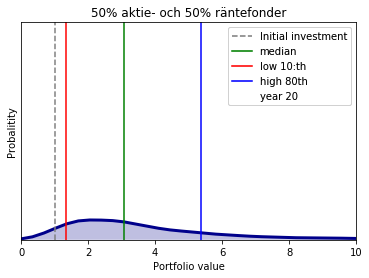

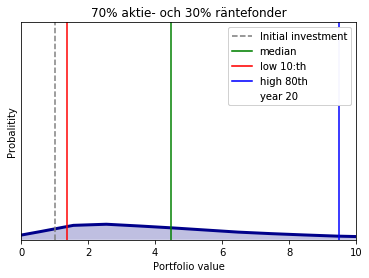

In [56]:
final_year_df, rounds_50_50 = SimReturns.monte_carlo_sim_returns(4000, 20, p1)
final_year_df, rounds_70_30 = SimReturns.monte_carlo_sim_returns(4000, 20, p2)

#SimReturns.plot_real_liquid(final_year_df)
#SimReturns.plot_real(final_year_df)
#SimReturns.plot_real_low_loss_liquid(final_year_df)
SimReturns.plot_real_liquid_animate(rounds_50_50, [], 20, '50_50', '50% aktie- och 50% räntefonder')
SimReturns.plot_real_liquid_animate(rounds_70_30, [], 20, '70_30', '70% aktie- och 30% räntefonder')
